In [ ]:
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras import models
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, image
from keras.applications import mobilenet_v2
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model

import math
from sklearn.metrics import confusion_matrix, classification_report

import glob
import os
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
keras.__version__

'2.5.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/expanded_threeclass/train'
validation_dir = '/content/drive/MyDrive/expanded_threeclass/validation'
test_dir = '/content/drive/MyDrive/expanded_threeclass/test'

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 8
num_of_categories = 3

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count, num_of_categories)) 
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False)
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels, generator 


In [ ]:
train_features, train_labels = extract_features(train_dir, 4809)
validation_features, validation_labels = extract_features(validation_dir, 600)
test_features, test_labels = extract_features(test_dir, 600)

Found 4809 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
train_features = np.reshape(train_features, (4809, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (600, 4 * 4 * 512))
test_features = np.reshape(test_features, (600, 4 * 4 * 512))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=70,
                    batch_size=70,
                    validation_data=(validation_features, validation_labels))

Epoch 1/70
69/69 [==============================] - 14s 37ms/step - loss: 1.1438 - acc: 0.4664 - val_loss: 0.7354 - val_acc: 0.6717
Epoch 2/70
69/69 [==============================] - 2s 32ms/step - loss: 0.6658 - acc: 0.7265 - val_loss: 0.5472 - val_acc: 0.7817
Epoch 3/70
69/69 [==============================] - 2s 31ms/step - loss: 0.5120 - acc: 0.7901 - val_loss: 0.5481 - val_acc: 0.7650
Epoch 4/70
69/69 [==============================] - 2s 31ms/step - loss: 0.4395 - acc: 0.8204 - val_loss: 0.5261 - val_acc: 0.7967
Epoch 5/70
69/69 [==============================] - 2s 31ms/step - loss: 0.3829 - acc: 0.8455 - val_loss: 0.6145 - val_acc: 0.7700
Epoch 6/70
69/69 [==============================] - 2s 31ms/step - loss: 0.3315 - acc: 0.8759 - val_loss: 0.5094 - val_acc: 0.8100
Epoch 7/70
69/69 [==============================] - 2s 32ms/step - loss: 0.2639 - acc: 0.9001 - val_loss: 0.6047 - val_acc: 0.7633
Epoch 8/70
69/69 [==============================] - 2s 32ms/step - loss: 0.2496 - 

In [ ]:
model.save('threeclass_transfer.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred_classes = model.predict_classes(validation_features, verbose=0)

from numpy import argmax
from keras.utils.np_utils import to_categorical

pred = argmax(to_categorical(pred_classes, 3 ), axis=1)
labels = argmax(validation_labels,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(confusion_matrix(labels, pred))
print(classification_report(labels, pred))

[[155  26  19]
 [ 12 169  19]
 [ 18  23 159]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       200
           1       0.78      0.84      0.81       200
           2       0.81      0.80      0.80       200

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.80       600
weighted avg       0.81      0.81      0.80       600



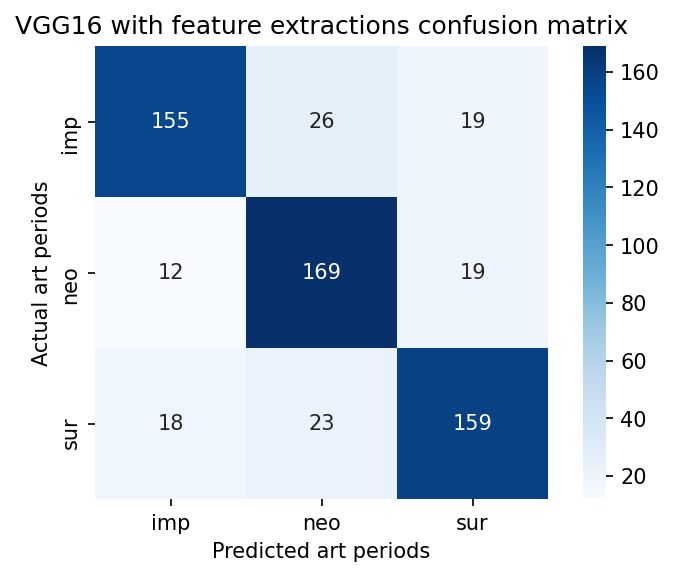

In [ ]:
vgg_confusion = confusion_matrix(labels, pred)
plt.figure(dpi=150)
sns.heatmap(vgg_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['imp', 'neo', 'sur'],
           yticklabels=['imp', 'neo', 'sur']);

plt.xlabel('Predicted art periods')
plt.ylabel('Actual art periods')
plt.title('VGG16 with feature extraction confusion matrix');

## Trying model out with a fresh image set

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/expanded_threeclass_transfer.h5')

In [ ]:
test_dir = '/content/drive/MyDrive/testmodel'

In [ ]:
test_features, test_labels, test_generator = extract_features(test_dir, 8)

Found 8 images belonging to 3 classes.


In [ ]:
test_features = np.reshape(test_features, (8, 4 * 4 * 512))

In [ ]:
from numpy import argmax
from keras.utils.np_utils import to_categorical

pred_classes = model.predict_classes(test_features, verbose=0)

pred = argmax(to_categorical(pred_classes, 3), axis=1)
labels = argmax(test_labels,axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred

array([0, 0, 0, 1, 1, 1, 1, 2])

In [ ]:
labels 

array([0, 0, 0, 1, 1, 1, 2, 2])

In [ ]:
test_generator.filenames

['impressionism/caillebotte.jpeg',
 'impressionism/monet.jpeg',
 'impressionism/monethaystacks.jpeg',
 'neoclassicism/david.jpeg',
 'neoclassicism/fragonard.jpeg',
 'neoclassicism/napoleon.jpeg',
 'surrealism/dali.jpeg',
 'surrealism/dali2.jpeg']

In [ ]:
test_generator.class_indices

{'impressionism': 0, 'neoclassicism': 1, 'surrealism': 2}